# Transfer Learning with VGG16

In this notebook, I will go over steps to retrain VGG16 net for the skin cancer dataset.

In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from keras.utils import to_categorical# convert to one-hot-encoding
        
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers.legacy import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


%matplotlib inline
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load in the Dataset

In [2]:
X_train = np.load("/kaggle/input/npyfiles/npy/256_192_train.npy")


In [3]:
y_train = np.load("/kaggle/input/npyfiles/npy/train_labels.npy")

In [4]:
X_val = np.load("/kaggle/input/npyfiles/npy/256_192_val.npy")

In [5]:
y_val = np.load("/kaggle/input/npyfiles/npy/val_labels.npy")

## Reshape the Dataset

In [6]:
X_train.shape, X_val.shape

((8111, 192, 256, 3), (902, 192, 256, 3))

In [7]:
y_train.shape, y_val.shape

((8111,), (902,))

In [8]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [9]:
y_train.shape, y_val.shape

((8111, 7), (902, 7))

In [10]:
!install Certificates.command

install: missing destination file operand after 'Certificates.command'
Try 'install --help' for more information.


## Load in Pretrained VGG16 Model

In [11]:
pre_trained_model = VGG16(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

58889256/58889256 [==============================] - 0s 0us/step


In [12]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model.layers))

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
19


In [13]:
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 6, 8, 512)


## Define the Model

In [14]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 128, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 128, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 128, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 64, 128)       0     

## Training

### Feature-Extraction

If performing fine tuning directly would result in a huge gradient, so it's better that we perform 3 epochs of feature extraction first so that weights of the final fully connected layer aren't completely random. The intuition for this is that if we don't perform feature-extraction, then the gradient will be too large and will change the pretrained weights too much.

In [16]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [17]:
batch_size = 64
epochs = 3
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

/tmp/ipykernel_26/3971016608.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/3
126/126 [==============================] - 107s 777ms/step - loss: 1.2576 - accuracy: 0.6344 - val_loss: 1.1104 - val_accuracy: 0.6496
Epoch 2/3
126/126 [==============================] - 90s 713ms/step - loss: 1.0823 - accuracy: 0.6650 - val_loss: 0.9502 - val_accuracy: 0.6853
Epoch 3/3
126/126 [==============================] - 93s 734ms/step - loss: 1.0257 - accuracy: 0.6703 - val_loss: 0.9948 - val_accuracy: 0.6540


### Fine Tuning Model

Let's fine tune the last convolutional block of VGG net. I only use learning_rate = 0.0001 with very high momentum = 0.9 and train for 35 epochs only so that the original weights of pretrained VGG net won't be changed too much. learning_rate_reduction function is used and will halve the learning_rate whenever the validation accuracy plateaus for 3 epochs. 

In [18]:
for layer in model.layers[:15]:
    layer.trainable = False

for layer in model.layers[15:]:
    layer.trainable = True

In [19]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 128, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 128, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 128, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 64, 128)       0     

By setting the last convolutional block to trainable, we are now retraining for half of the hyperparameters

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=3)

In [22]:
batch_size = 64
epochs = 30     
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size), callbacks=[learning_rate_reduction])

/tmp/ipykernel_26/122660716.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),


Epoch 1/30
126/126 [==============================] - 92s 714ms/step - loss: 0.8883 - acc: 0.6902 - val_loss: 0.7665 - val_acc: 0.7076 - lr: 1.0000e-04
Epoch 2/30
126/126 [==============================] - 90s 708ms/step - loss: 0.7722 - acc: 0.7236 - val_loss: 0.7690 - val_acc: 0.7165 - lr: 1.0000e-04
Epoch 3/30
126/126 [==============================] - 88s 693ms/step - loss: 0.7292 - acc: 0.7444 - val_loss: 0.7705 - val_acc: 0.6920 - lr: 1.0000e-04
Epoch 4/30
126/126 [==============================] - 90s 715ms/step - loss: 0.6796 - acc: 0.7592 - val_loss: 0.6665 - val_acc: 0.7545 - lr: 1.0000e-04
Epoch 5/30
126/126 [==============================] - 87s 692ms/step - loss: 0.6517 - acc: 0.7646 - val_loss: 0.7187 - val_acc: 0.6964 - lr: 1.0000e-04
Epoch 6/30
126/126 [==============================] - 91s 720ms/step - loss: 0.6212 - acc: 0.7707 - val_loss: 0.6742 - val_acc: 0.7321 - lr: 1.0000e-04
Epoch 7/30
126/126 [==============================] - ETA: 0s - loss: 0.5964 - acc: 0.78

In [23]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

29/29 [==============================] - 5s 161ms/step - loss: 0.5837 - acc: 0.7949
Validation: accuracy = 0.794900  ;  loss_v = 0.583659


Our model clearly overfits the training dataset. But we do observe some improvement with validation accuracy, which is clearly better than the baseline model! Having around 3% improvement from the baseline model justifies some more training time. This improvement proves that weights of pretrained model learned from ImageNet generalize to our dataset, which is completely different from ImageNet. 

## Testing

In [24]:
X_test = np.load("/kaggle/input/npyfiles/npy/256_192_test.npy")

In [25]:
y_test = np.load("/kaggle/input/npyfiles/npy/test_labels.npy")
y_test = to_categorical(y_test)

In [26]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 [==============================] - 6s 172ms/step - loss: 0.6051 - acc: 0.8044
Test: accuracy = 0.804391  ;  loss = 0.605093


In [27]:
model.save("VGG16.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Text(0.5, 1.0, 'Training and validation loss')

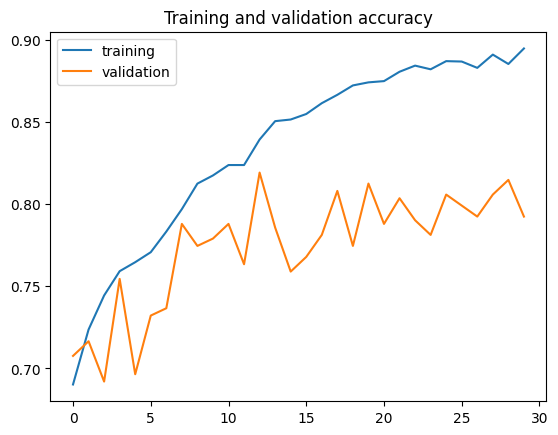

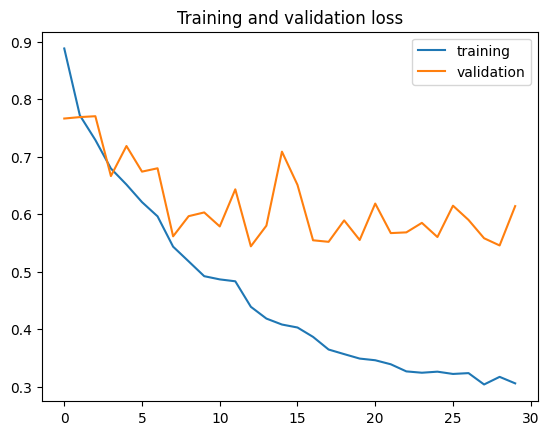

In [28]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')